# Notebook 32: Assigning SFR and [Fe/H] to galaxies sampled from the GSMF

## Prelude

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.stats import norm
from pathlib import Path
from astropy.cosmology import WMAP9 as cosmo
import astropy.units as u

import sys
sys.path.append('../src/')
from sfr import MZR, SFMR, Corrections
from imf import GSMF
from utils import ZOH_to_FeH, ZOH_to_FeH2, ZOH_from_FeH, FeH_to_Z

In [38]:
DATA_FOLDER = Path('.', 'NB12_GalaxyGrid')

In [3]:
random_seed = 42
LN10 = np.log(10)
LOGE = np.log10(np.e)

In [4]:
logm_min = 7
logm_max = 12

In [5]:
highmet_MZR = 'KK04'
highmet_SFMR = 'none'
highmet_GSMF_fixedslope =  True

midmet_MZR = 'M09'
midmet_SFMR = 'moderate'
midmet_GSMF_fixedslope =  True

lowmet_MZR = 'PP04'
lowmet_SFMR = 'sharp'
lowmet_GSMF_fixedslope =  True

In [6]:
def galaxy_mzr_scatter():
    return 0.14

def mzr_scatter(logm): #dex
    if logm > 9.5:
        sigma0 = 0.1
    else:
        sigma0 = -0.04*logm + 0.48
    return sigma0

def mzr_scattered(mean_zoh, logm):
    sigma0 = mzr_scatter(logm)
    sigmag = galaxy_mzr_scatter()
    scattered1 = norm.rvs(loc=mean_zoh, scale=sigma0, size=1, random_state=random_seed)[0]
    scattered2 = norm.rvs(loc=scattered1, scale=sigmag, size=1, random_state=random_seed)[0]
    return scattered2

def sfmr_scatter(logm):
    return 0.3

## Desmontrating the SFR-Metallicity relation 

In [7]:
bg_mzr_model = midmet_MZR
bg_sfmr_flattening = midmet_SFMR
bg_gsmf_slope_fixed = midmet_GSMF_fixedslope
bg_scatter = False

In [8]:
bgplot_zs = np.arange(0,11,1)
bgplot_z_cnorm = bgplot_zs.max() - bgplot_zs.min()
bgmass_array = np.linspace(logm_min, logm_max, 200)

In [9]:
bgplot_zoh_array = np.empty((0, bgmass_array.shape[0]), np.float64)
bgplot_zoh_dev_array = np.empty((0, bgmass_array.shape[0]), np.float64)
bgplot_feh_array = np.empty((0, bgmass_array.shape[0]), np.float64)
bgplot_feh_mask_array = np.empty((0, bgmass_array.shape[0]), np.float64)
bgplot_gsmf_array = np.empty((0, bgmass_array.shape[0]), np.float64)

for z in bgplot_zs:
    mzr = MZR(z, bg_mzr_model)
    mzr.set_params()
    mean_zohs = [mzr.zoh(logm) for logm in bgmass_array]
    
    gsmf = GSMF(z, bg_gsmf_slope_fixed)
    gsmfs = np.array([[np.float64(gsmf.gsmf(logm)) for logm in bgmass_array]])
    
    if bg_scatter:
        zohs = np.array([[mzr_scattered(mean_zoh, logm) for mean_zoh, logm in zip(mean_zohs, bgmass_array)]])
    else:
        zohs = np.array([mean_zohs])
    
    if bg_scatter:
        zoh_devs = np.array([[mzr_scatter(logm)/(zoh-mean_zoh) for logm, zoh, mean_zoh in zip(bgmass_array, zohs[0], mean_zohs)]])
    else:
        zoh_devs = np.array([[0 for logm, zoh, mean_zoh in zip(bgmass_array, zohs[0], mean_zohs)]])
    fehs = np.array([[ZOH_to_FeH(zoh) for zoh in zohs[0]]])
    
    feh_mask = np.ones(fehs.shape)
    for i, feh in enumerate(fehs[0]):
        if feh>1 or feh<-3:
            feh_mask[0,i] = 0 
    feh_mask = feh_mask.astype(bool)
    
    bgplot_zoh_array = np.append(bgplot_zoh_array, zohs, axis=0)
    bgplot_zoh_dev_array = np.append(bgplot_zoh_dev_array, zoh_devs, axis=0)
    bgplot_feh_array = np.append(bgplot_feh_array, fehs, axis=0)
    bgplot_feh_mask_array = np.append(bgplot_feh_mask_array, feh_mask, axis=0)
    bgplot_gsmf_array = np.append(bgplot_gsmf_array, gsmfs, axis=0)

In [10]:
bgplot_sfr_array = np.empty((0, bgmass_array.shape[0]), np.float64)
bgplot_sfr_mask_array = np.empty((0, bgmass_array.shape[0]), np.float64)

for z, relative_devs in zip(bgplot_zs, bgplot_zoh_dev_array):
    sfmr = SFMR(z, flattening=bg_sfmr_flattening)
    mean_sfrs = [sfmr.sfr(logm) for logm in bgmass_array]
    
    if bg_scatter:
        sfr_devs = [sfmr_scatter(logm)/relative_dev for logm, relative_dev in zip(bgmass_array, relative_devs)]
    else:
        sfr_devs = [0 for logm, relative_dev in zip(bgmass_array, relative_devs)]
    sfrs = np.array([[mean_sfr+sfr_dev for mean_sfr, sfr_dev in zip(mean_sfrs, sfr_devs)]])
    
    sfr_mask = np.ones(sfrs.shape)
    for i, sfr in enumerate(sfrs[0]):
        if np.abs(sfr)>3.3:
            sfr_mask[0,i] = 0
    sfr_mask = sfr_mask.astype(bool)
    
    bgplot_sfr_array = np.append(bgplot_sfr_array, sfrs, axis=0)
    bgplot_sfr_mask_array = np.append(bgplot_sfr_mask_array, sfr_mask, axis=0)

bgplot_mask_array = np.logical_and(bgplot_feh_mask_array, bgplot_sfr_mask_array)

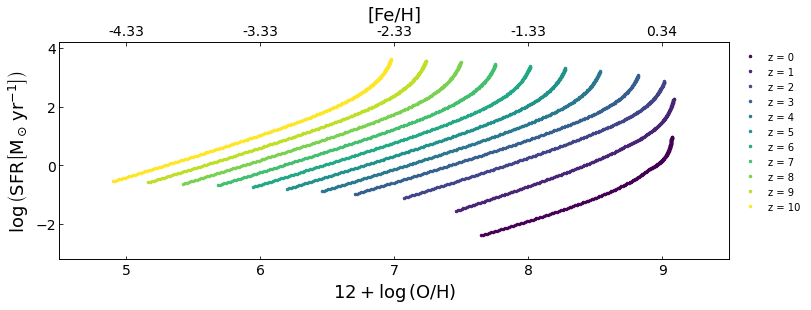

In [11]:
zoh_minplot = 4.5
zoh_maxplot = 9.5


fig, ax = plt.subplots(figsize=(12,4))

for z, zohs, sfrs in zip(bgplot_zs, bgplot_zoh_array, bgplot_sfr_array):
    c = cm.viridis((z-bgplot_zs.min())/bgplot_z_cnorm)
    ax.plot(zohs, sfrs, '.', label=f'z = {z:.0f}', c=c, markersize=5, lw=2)

ax.set_ylabel(r'$\log\left(\mathrm{SFR\left[\mathrm{M}_\odot\,\mathrm{yr}^{-1}\right]}\right)$', fontsize=18)
ax.set_ylim(-3.2, 4.2)
ax.legend(loc=(1.01, 0.2), frameon=False)

ax.set_xticks(np.arange(5,10,1))
ax.set_xlim(zoh_minplot, zoh_maxplot)
ax.set_xlabel(r'$12+\log\left(\mathrm{O/H}\right)$', fontsize=18)

ax2 = ax.twiny()
ax2.set_xticks(np.arange(5,10,1))
ax2.set_xlim(zoh_minplot, zoh_maxplot)
ax2.set_xticklabels([f'{x:.2f}' for x in [ZOH_to_FeH(zoh) for zoh in np.arange(5,10,1)]])
ax2.set_xlabel('[Fe/H]', fontsize=18)

ax.tick_params(axis='both', direction='in', labelsize=14)
ax2.tick_params(axis='x', direction='in', labelsize=14)

In [12]:
bgplot_sfr_list = list()
bgplot_feh_list = list()
bgplot_zoh_list = list()
bgplot_gsmf_list = list()

for sfrs, fehs, zohs, gsmfs, mask in zip(bgplot_sfr_array, bgplot_feh_array, bgplot_zoh_array, bgplot_gsmf_array, bgplot_mask_array):
    f_gsmfs = gsmfs[mask]
    f_fehs = fehs[mask]
    f_zohs = zohs[mask]
    f_sfrs = sfrs[mask]
    f_sfrs = np.tile(f_sfrs, (f_fehs.shape[0],1))
    
    corrections = Corrections(f_fehs, f_sfrs)
    corrections.load_data()
    corrs = np.diag(corrections.get_corrections())
    corr_sfrs = f_sfrs[0]+corrs
    
    bgplot_gsmf_list.append(f_gsmfs)
    bgplot_zoh_list.append(f_zohs)
    bgplot_feh_list.append(f_fehs)
    bgplot_sfr_list.append(corr_sfrs)

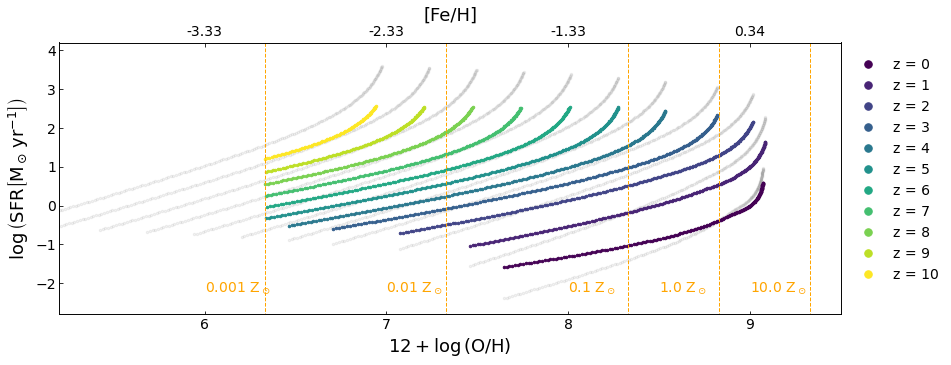

In [13]:
zoh_minplot = 5.2
zoh_maxplot = 9.5
sfr_minplot = -2.8
sfr_maxplot = 4.2

fig, ax = plt.subplots(figsize=(14,5))

for z, zohs, sfrs in zip(bgplot_zs, bgplot_zoh_array, bgplot_sfr_array):
    ax.plot(zohs, sfrs, '.', c='gray', markersize=5, lw=2, alpha=0.1)
    
for z, zohs, sfrs in zip(bgplot_zs, bgplot_zoh_list, bgplot_sfr_list):
    c = cm.viridis((z-bgplot_zs.min())/bgplot_z_cnorm)
    ax.plot(zohs, sfrs, '.', label=f'z = {z:.0f}', c=c, markersize=5, lw=2)

for feh in np.arange(-3, 2, 1):
    zoh = ZOH_from_FeH(feh)
    ax.vlines(zoh, -3, 5, linestyle='--', color='orange', linewidth=1)
    ax.text(zoh-0.33, -2.2, f'{10.**feh} Z$_\odot$', color='orange', fontsize=14)
    
ax.set_ylabel(r'$\log\left(\mathrm{SFR\left[\mathrm{M}_\odot\,\mathrm{yr}^{-1}\right]}\right)$', fontsize=18)
ax.set_ylim(sfr_minplot, sfr_maxplot)
lgnd = ax.legend(loc=(1.01, 0.1), scatterpoints=1, frameon=False, fontsize=14, markerscale=3)

ax.set_xticks(np.arange(5,10,1))
ax.set_xlim(zoh_minplot, zoh_maxplot)
ax.set_xlabel(r'$12+\log\left(\mathrm{O/H}\right)$', fontsize=18)

ax2 = ax.twiny()
ax2.set_xticks(np.arange(5,10,1))
ax2.set_xlim(zoh_minplot, zoh_maxplot)
ax2.set_xticklabels([f'{x:.2f}' for x in [ZOH_to_FeH(zoh) for zoh in np.arange(5,10,1)]])
ax2.set_xlabel('[Fe/H]', fontsize=18)


ax.tick_params(axis='both', direction='in', labelsize=14)
ax2.tick_params(axis='x', direction='in', labelsize=14)

In [14]:
bgplot_gsmf_array = np.concatenate(bgplot_gsmf_list)
bgplot_gsmf_max = bgplot_gsmf_array.max()
bgplot_gsmf_min = bgplot_gsmf_array.min()
bgplot_gsmf_cnorm =bgplot_gsmf_max - bgplot_gsmf_min

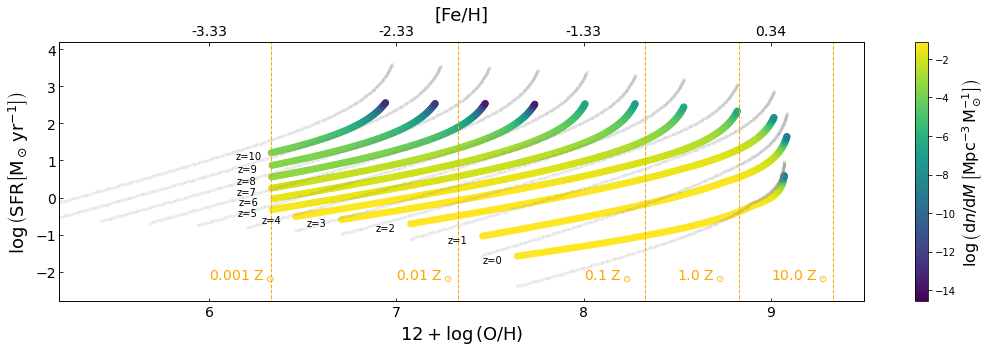

In [15]:
zoh_minplot = 5.2
zoh_maxplot = 9.5
sfr_minplot = -2.8
sfr_maxplot = 4.2

fig, ax = plt.subplots(figsize=(15,5), tight_layout=True)

for z, zohs, sfrs in zip(bgplot_zs, bgplot_zoh_array, bgplot_sfr_array):
    ax.plot(zohs, sfrs, '.', c='gray', markersize=5, lw=2, alpha=0.1)
    
for z, zohs, sfrs, gsmfs in zip(bgplot_zs, bgplot_zoh_list, bgplot_sfr_list, bgplot_gsmf_list):
    c = gsmfs-bgplot_gsmf_array.min()/bgplot_gsmf_cnorm 
    ax.scatter(zohs, sfrs, c=c, cmap='viridis', vmin=bgplot_gsmf_min, vmax=bgplot_gsmf_max)
    ax.text(zohs[1]-0.2, sfrs[1]-0.2, f'z={z}', fontsize=10)

for feh in np.arange(-3, 2, 1):
    zoh = ZOH_from_FeH(feh)
    ax.vlines(zoh, -3, 5, linestyle='--', color='orange', linewidth=1)
    ax.text(zoh-0.33, -2.2, f'{10.**feh} Z$_\odot$', color='orange', fontsize=14)
    
ax.set_ylabel(r'$\log\left(\mathrm{SFR\left[\mathrm{M}_\odot\,\mathrm{yr}^{-1}\right]}\right)$', fontsize=18)
ax.set_ylim(sfr_minplot, sfr_maxplot)

ax.set_xticks(np.arange(5,10,1))
ax.set_xlim(zoh_minplot, zoh_maxplot)
ax.set_xlabel(r'$12+\log\left(\mathrm{O/H}\right)$', fontsize=18)

ax2 = ax.twiny()
ax2.set_xticks(np.arange(5,10,1))
ax2.set_xlim(zoh_minplot, zoh_maxplot)
ax2.set_xticklabels([f'{x:.2f}' for x in [ZOH_to_FeH(zoh) for zoh in np.arange(5,10,1)]])
ax2.set_xlabel('[Fe/H]', fontsize=18)

ax.tick_params(axis='both', direction='in', labelsize=14)
ax2.tick_params(axis='x', direction='in', labelsize=14)

sm = cm.ScalarMappable(cmap=cm.viridis, norm=plt.Normalize(vmin=bgplot_gsmf_min, vmax=bgplot_gsmf_max))
cb = fig.colorbar(sm)
cb.set_label(r'$\log\left(\mathrm{d}n/\mathrm{d}M\,\left[\mathrm{Mpc}^{-3}\,\mathrm{M}_\odot^{-1}\right]\right)$', fontsize=16)

plt.savefig('sfrgrid_relatorio.png')

## Sampling galaxies from the GSMF

In [16]:
from sampling import GalaxySampling

In [17]:
sample_redshift_array = np.arange(0.01, 10, 1)
logm_min = 7
logm_max = 12
samples_per_redshift = 5
mzr_model = midmet_MZR
sfmr_flattening = midmet_SFMR
gsmf_slope_fixed = midmet_GSMF_fixedslope
sampling_mode = 'mass'
include_scatter = False
random_state = 42

In [18]:
galaxysampling = GalaxySampling(sample_redshift_array, 
                                logm_min, 
                                logm_max, 
                                samples_per_redshift,
                                mzr_model, 
                                sfmr_flattening,
                                gsmf_slope_fixed,
                                sampling_mode,
                                include_scatter,
                                random_state)

In [19]:
%%time
galaxysampling.generate_sample()

/home/lucasmdesa/git_repos/environIMF/notebooks/../src/sampling.py:661: RuntimeWarning: divide by zero encountered in double_scalars
  zoh_rel_devs = [self._mzr_scatter(logm)/(zoh-mean_zoh) for logm, zoh, mean_zoh in zip(mass_sample, zohs.flatten(), mean_zohs)]


CPU times: user 1min 12s, sys: 180 ms, total: 1min 12s
Wall time: 1min 15s


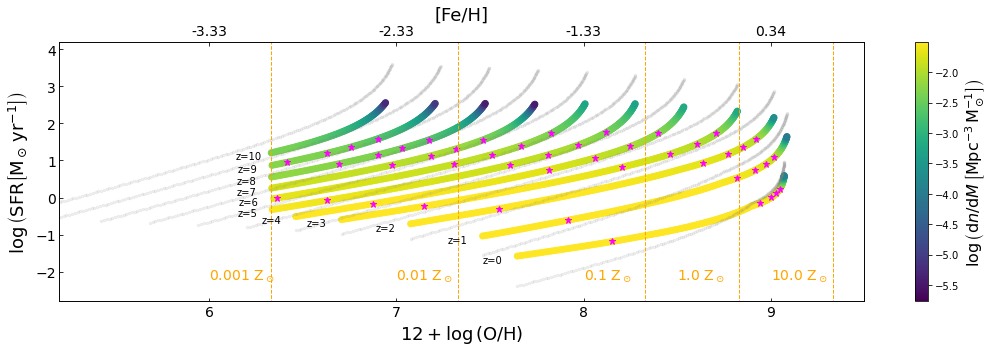

In [20]:
zoh_list = galaxysampling.zoh_list
feh_list = galaxysampling.feh_list
sfr_list = galaxysampling.sfr_list
gsmf_list = galaxysampling.gsmf_list
mass_list = galaxysampling.mass_list

fig, ax = plt.subplots(figsize=(15,5), tight_layout=True)
zoh_minplot = 5.2
zoh_maxplot = 9.5
sfr_minplot = -2.8
sfr_maxplot = 4.2
gsmf_max = np.concatenate(gsmf_list).max()
gsmf_min = np.concatenate(gsmf_list).min()
cnorm = gsmf_max - gsmf_min
z_cnorm = sample_redshift_array.max() - sample_redshift_array.min()

for z, zohs, sfrs in zip(bgplot_zs, bgplot_zoh_array, bgplot_sfr_array):
    ax.plot(zohs, sfrs, '.', c='gray', markersize=5, lw=2, alpha=0.1)
    
for z, zohs, sfrs, gsmfs in zip(bgplot_zs, bgplot_zoh_list, bgplot_sfr_list, bgplot_gsmf_list):
    c = gsmfs-bgplot_gsmf_array.min()/bgplot_gsmf_cnorm 
    ax.scatter(zohs, sfrs, c=c, cmap='viridis', vmin=bgplot_gsmf_min, vmax=bgplot_gsmf_max)
    ax.text(zohs[1]-0.2, sfrs[1]-0.2, f'z={z}', fontsize=10)

grid_descr = ''
for z, masses, zohs, sfrs in zip(sample_redshift_array, mass_list, zoh_list, sfr_list):
    color = cm.jet((z-sample_redshift_array.min())/z_cnorm)
    ax.plot(zohs, sfrs, '*', c='magenta', markersize=7, lw=2)
    line = ''.join([r'$\log\left(M_i/M_\odot\right)$ = {}'.format(masses)]+[' \n'])
    grid_descr += line
    
for feh in np.arange(-3, 2, 1):
    zoh = ZOH_from_FeH(feh)
    ax.vlines(zoh, -3, 5, linestyle='--', color='orange', linewidth=1)
    ax.text(zoh-0.33, -2.2, f'{10.**feh} Z$_\odot$', color='orange', fontsize=14)
    
ax.set_ylabel(r'$\log\left(\mathrm{SFR\left[\mathrm{M}_\odot\,\mathrm{yr}^{-1}\right]}\right)$', fontsize=18)
ax.set_ylim(sfr_minplot, sfr_maxplot)

ax.set_xticks(np.arange(5,10,1))
ax.set_xlim(zoh_minplot, zoh_maxplot)
ax.set_xlabel(r'$12+\log\left(\mathrm{O/H}\right)$', fontsize=18)

ax2 = ax.twiny()
ax2.set_xticks(np.arange(5,10,1))
ax2.set_xlim(zoh_minplot, zoh_maxplot)
ax2.set_xticklabels([f'{x:.2f}' for x in [ZOH_to_FeH(zoh) for zoh in np.arange(5,10,1)]])
ax2.set_xlabel('[Fe/H]', fontsize=18)

ax.tick_params(axis='both', direction='in', labelsize=14)
ax2.tick_params(axis='x', direction='in', labelsize=14)

sm = cm.ScalarMappable(cmap=cm.viridis, norm=plt.Normalize(vmin=gsmf_min, vmax=gsmf_max))
cb = fig.colorbar(sm)
cb.set_label(r'$\log\left(\mathrm{d}n/\mathrm{d}M\,\left[\mathrm{Mpc}^{-3}\,\mathrm{M}_\odot^{-1}\right]\right)$', fontsize=16)

#fig.text(0, -0.6, grid_descr);

#### Metallicity distribution

In [21]:
density_array = galaxysampling.density_array
ndensity_array = galaxysampling.ndensity_array
dzoh_lims_array = galaxysampling.zoh_bin_array
zoh_array = galaxysampling.zoh_array

In [22]:
feh_array = np.empty(zoh_array.shape, np.float64)
for i, row in enumerate(zoh_array):
    for j, zoh in enumerate(row):
        feh = ZOH_to_FeH(zoh)
        feh_array[i,j] = feh

In [23]:
dFeH_lims_array = np.empty(dzoh_lims_array.shape, np.float64)
dFeH_array = np.empty((dzoh_lims_array.shape[0], dzoh_lims_array.shape[1]-1), np.float64)

for i, row in enumerate(dzoh_lims_array):
    for j, zoh in enumerate(row):
        FeH = ZOH_to_FeH(zoh)
        dFeH_lims_array[i,j] = FeH
        
for i, row in enumerate(dFeH_lims_array):
    for j, (FeH1, FeH2) in enumerate(zip(row[:-1], row[1:])):
        dFeH = np.abs(FeH2 - FeH1)
        dFeH_array[i,j] = dFeH

In [24]:
dndFeH_array = np.divide(density_array, dFeH_array)

In [25]:
dNdFeH_array= np.empty(dndFeH_array.shape, np.float64)

for i, (z, row) in enumerate(zip(sample_redshift_array, dndFeH_array)):
    dVc = (4*np.pi*u.sr * cosmo.differential_comoving_volume(z)).value
    for j, dndFeH in enumerate(row):
        dNdFeH = dndFeH * dVc
        dNdFeH_array[i,j] = dNdFeH

In [26]:
normalized_dNdFeH_array = np.empty(dNdFeH_array.shape, np.float64)

for i, row in enumerate(dNdFeH_array):
    normalized_row = row / row.sum()
    normalized_dNdFeH_array[i] = normalized_row

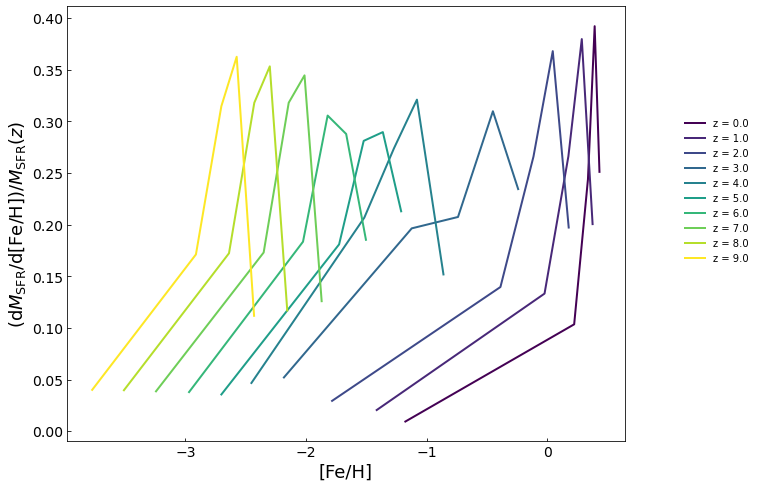

In [27]:
fig, ax = plt.subplots(figsize=(10,8))
dNdFeH_plot_cnorm = sample_redshift_array.max() - sample_redshift_array.min()

for z, fehs, dNdFeHs in zip(sample_redshift_array, feh_array, normalized_dNdFeH_array):
    color = cm.viridis((z-sample_redshift_array.min())/dNdFeH_plot_cnorm)
    ax.plot(fehs, dNdFeHs, '-', c=color, label=f'z = {z:.1f}', lw=2, markersize=16)
    
ax.set_xlabel('[Fe/H]', fontsize=18)
ax.set_ylabel(r'$\left(\mathrm{d}M_\mathrm{SFR}/\mathrm{d[Fe/H]}\right)/M_\mathrm{SFR}(z)$', fontsize=18)
ax.tick_params(axis='both', direction='in', labelsize=14)
    
#ax.set_yscale('log')
ax.legend(loc=(1.1, 0.4), frameon=False)

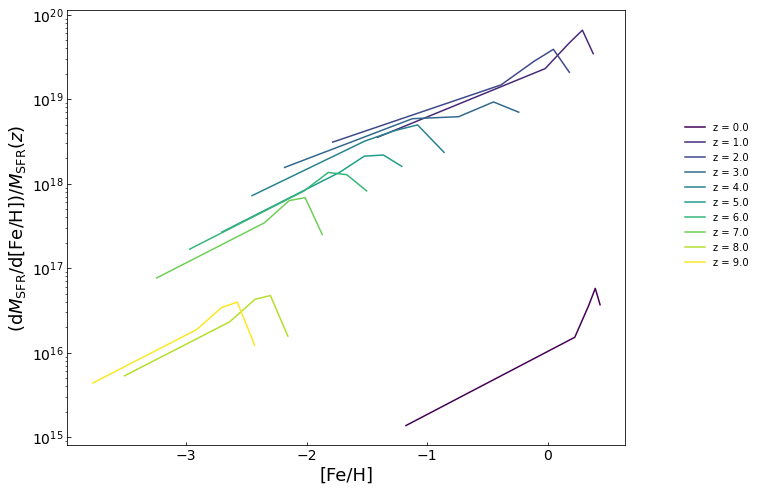

In [28]:
fig, ax = plt.subplots(figsize=(10, 8))
dNdFeH_plot_cnorm = sample_redshift_array.max() - sample_redshift_array.min()

for z, fehs, dNdFeHs in zip(sample_redshift_array, feh_array, dNdFeH_array):
    color = cm.viridis((z-sample_redshift_array.min())/dNdFeH_plot_cnorm)
    ax.plot(fehs, dNdFeHs, c=color, label=f'z = {z:.1f}')
    
ax.set_xlabel('[Fe/H]', fontsize=18)
ax.set_ylabel(r'$\left(\mathrm{d}M_\mathrm{SFR}/\mathrm{d[Fe/H]}\right)/M_\mathrm{SFR}(z)$', fontsize=18)
ax.tick_params(axis='both', direction='in', labelsize=14)
ax.set_yscale('log')
ax.legend(loc=(1.1, 0.4), frameon=False)

#### Saving the grid

In [29]:
import pandas as pd

In [39]:
GRIDFILE = Path(DATA_FOLDER, 'z0-10-1_5bin_galaxygrid.pkl')

In [31]:
n_columns = 6 # redshift, galaxy mass, density, sfr, zoh, feh
columns = ['Redshift', 'Log(Mgal/Msun)', 'Log(Number density [Mpc-3 Msun-1])', 'SFR [Msun yr-1]', '12+log(O/H)', '[Fe/H]']

grid_array = np.empty((0, n_columns), np.float64)
for z, masses, densities, sfrs, zohs, fehs in zip(sample_redshift_array, mass_list, gsmf_list,  sfr_list, zoh_list, feh_list):
    lines = np.array([masses, densities, sfrs, zohs, fehs], np.float64).T
    for line in lines:
        grid_array = np.append(grid_array, [np.concatenate(([np.float64(z)], line))], axis=0)

grid_df = pd.DataFrame(grid_array, columns=columns)

In [32]:
grid_df

,Redshift,Log(Mgal/Msun),Log(Number density [Mpc-3 Msun-1]),SFR [Msun yr-1],12+log(O/H),[Fe/H]
0,0.01,11.003143,-3.239432,0.239670,9.047231,0.434461
1,0.01,10.663365,-2.744230,0.117166,9.027321,0.394642
2,0.01,10.350333,-2.475242,0.006151,8.999517,0.339034
3,0.01,9.934082,-2.241326,-0.138303,8.942340,0.224680
4,0.01,7.870006,-1.501990,-1.176931,8.154459,-1.175541
5,1.01,11.004360,-3.402835,1.094579,9.018733,0.377467
6,1.01,10.667811,-2.909475,0.912967,8.973960,0.287919
7,1.01,10.358573,-2.643631,0.749452,8.918355,0.176710
8,1.01,9.947751,-2.415168,0.537632,8.819421,-0.021157
9,1.01,7.848946,-1.645590,-0.604049,7.916736,-1.413264


In [33]:
import seaborn as sns

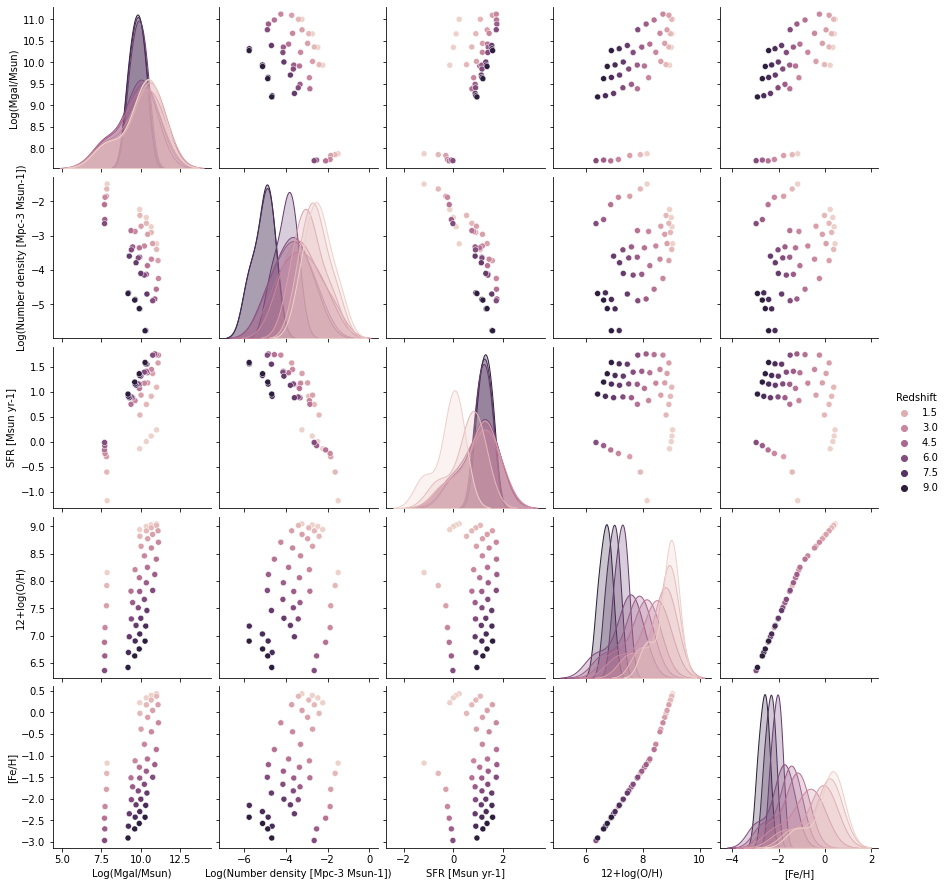

In [34]:
sns.pairplot(grid_df, hue='Redshift')

In [40]:
grid_df.to_pickle(GRIDFILE)